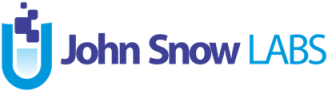

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/misc/Custom_Chat_Template_Config.ipynb)

**LangTest** is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, Spacy** models or **OpenAI, Cohere, AI21, Hugging Face Inference API and Azure-OpenAI** based LLMs, it has got you covered. You can test any Named Entity Recognition (NER), Text Classification, fill-mask, Translation model using the library. We also support testing LLMS for Question-Answering, Summarization and text-generation tasks on benchmark datasets. The library supports 100+ out of the box tests. For a complete list of supported test categories, please refer to the [documentation](http://langtest.org/docs/pages/docs/test_categories).


# Getting started with LangTest

In [ ]:
!pip install "langtest[openai,transformers]==2.5.0"

# Harness and Its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a NLP model on a given task using test data and generates a report with test results.Harness can be imported from the LangTest library in the following way.

In [1]:
# Import Harness from the LangTest library
from langtest import Harness

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.

Here is a list of the different parameters that can be passed to the Harness function:

<br/>


| Parameter  | Description |  
| - | - |
|**task**     |Task for which the model is to be evaluated (question-answering or summarization)|
| **model**     | Specifies the model(s) to be evaluated. This parameter can be provided as either a dictionary or a list of dictionaries. Each dictionary should contain the following keys: <ul><li>model (mandatory): 	PipelineModel or path to a saved model or pretrained pipeline/model from hub.</li><li>hub (mandatory): Hub (library) to use in back-end for loading model from public models hub or from path</li></ul>|
| **data**      | The data to be used for evaluation. A dictionary providing flexibility and options for data sources. It should include the following keys: <ul><li>data_source (mandatory): The source of the data.</li><li>subset (optional): The subset of the data.</li><li>feature_column (optional): The column containing the features.</li><li>target_column (optional): The column containing the target labels.</li><li>split (optional): The data split to be used.</li><li>source (optional): Set to 'huggingface' when loading Hugging Face dataset.</li></ul> |
| **config**    | Configuration for the tests to be performed, specified in the form of a YAML file. |

<br/>
<br/>

## Robustness testing of LLMs with LangTest

Robustness testing aims to evaluate the ability of a model to maintain consistent performance when faced with various perturbations or modifications in the input data. For LLMs, this involves understanding how changes in capitalization, punctuation, typos, contractions, and contextual information affect their prediction performance.

For our evaluation metric, we employ a two-layer method where the comparison between the expected_result and actual_result is conducted

## Configuration of Custom Chat Template



In [ ]:
import os


os.environ["HUGGINGFACE_API_KEY"] = "<your-huggingface-api-key>"
os.environ["OPENAI_API_KEY"] = "<your-openai-api-key>"

In [3]:
meta_template = """
{{- bos_token }}\n

{%- if messages[0]['role'] == 'system' %} 
    {%- set system_message = messages[0]['content']|trim %} 
    {%- set messages = messages[1:] %} 
{%- else %} 
    {%- set system_message = "You are a helpful assistant. Provide a short answer based on the given context and question in plain text." %} 
{%- endif %}

{#- System message #}
{{- "<|start_header_id|>system<|end_header_id|>\\n" }}
{{- system_message }}
{{- "<|eot_id|>" }}

{%- for message in messages %} 
    {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\\n' + message['content'] | trim + '<|eot_id|>' }} 
{%- endfor %} 
{{- '<|start_header_id|>assistant<|end_header_id|>\\n' }}

"""

In [4]:
prompt_config =  {
    "NQ-open": {
        "prompt_type": "chat",
        "instructions": "Write a short answer based on the given context and question in plain text.",
        "user_prompt": "You are a helpful assistant. Provide a short answer based on the given context and question.\n {question}",
        "examples": [{
            "user": {
                "question": "What is the capital of France?",
                "context": "France is a country in Europe."
            },
            "ai": {
                "answer": "Paris"
            }
      }]
    }
}

In [5]:
from langtest.types import HarnessConfig


test_config: HarnessConfig = {
    "evaluation": {
        "metric": "llm_eval",
        "model": "gpt-4o",
        "hub": "openai",
    },
    "prompt_config": prompt_config,
    "model_parameters": {
        "chat_template": meta_template,
        "max_tokens": 50,
        "task": "text-generation",
        "device": 0, # Use GPU 0
    },
    "tests": {
        "defaults": {
            "min_pass_rate": 0.6,
        },
        "robustness": {
            "uppercase": {
                "min_pass_rate": 0.7,
            },
            "add_slangs": {
                "min_pass_rate": 0.7,
            },
            "add_ocr_typo": {
                "min_pass_rate": 0.7,
            },
        },
    }
}

### Harness setup

In [8]:
harness = Harness(
    task="question-answering",
    model={
        "model": "meta-llama/Llama-3.2-3B-Instruct", 
        "hub": "huggingface",
        "type": "chat",
        },
    data={"data_source": "NQ-open",
          "split": "test-tiny"},
    config=test_config,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


Test Configuration : 
 {
 "evaluation": {
  "metric": "llm_eval",
  "model": "gpt-4o",
  "hub": "openai"
 },
 "prompt_config": {
  "NQ-open": {
   "prompt_type": "chat",
   "instructions": "Write a short answer based on the given context and question in plain text.",
   "user_prompt": "You are a helpful assistant. Provide a short answer based on the given context and question.\n {question}",
   "examples": [
    {
     "user": {
      "question": "What is the capital of France?",
      "context": "France is a country in Europe."
     },
     "ai": {
      "answer": "Paris"
     }
    }
   ]
  }
 },
 "model_parameters": {
  "chat_template": "\n{{- bos_token }}\n\n\n{%- if messages[0]['role'] == 'system' %} \n    {%- set system_message = messages[0]['content']|trim %} \n    {%- set messages = messages[1:] %} \n{%- else %} \n    {%- set system_message = \"You are a helpful assistant. Provide a short answer based on the given context and question in plain text.\" %} \n{%- endif %}\n\n{#- S

**Note**
- you can change the metric in the `config.yaml` file that is saved in the `saved_model_reponse` folder or you can change the configiration using `harness.configure()` method like shown below.

In [9]:
harness._testcases = None

In [10]:
harness.generate()

Generating testcases...: 100%|██████████| 1/1 [00:00<?, ?it/s]


### check the testcases

In [11]:
harness.testcases()

,category,test_type,original_question,perturbed_question
0,robustness,uppercase,on the 6th day of christmas my true love sent ...,ON THE 6TH DAY OF CHRISTMAS MY TRUE LOVE SENT ...
1,robustness,uppercase,how many 5 star generals are there in the us,HOW MANY 5 STAR GENERALS ARE THERE IN THE US
2,robustness,uppercase,who killed natalie and ann in sharp objects,WHO KILLED NATALIE AND ANN IN SHARP OBJECTS
3,robustness,uppercase,how many costco locations are there in the us,HOW MANY COSTCO LOCATIONS ARE THERE IN THE US
4,robustness,uppercase,who played grand moff tarkin in rogue one,WHO PLAYED GRAND MOFF TARKIN IN ROGUE ONE
...,...,...,...,...
104,robustness,add_ocr_typo,who has the most followers on the twitter,ivho has tlie moft followers on the twitter
105,robustness,add_ocr_typo,who said it's not what your country can do for...,avho said it's n^ot vhat y0ur couutry c^an do ...
106,robustness,add_ocr_typo,when does lil wayne new album drop 2018,ivhen does lil wayne n^ew album drop 2018
107,robustness,add_ocr_typo,the khajuraho temples are especially well know...,tbe khajuraho temples are efpecially w^ell kno...


### Run the tests on the Model

In [12]:
harness.run()

Running testcases... : 100%|██████████| 109/109 [04:56<00:00,  2.72s/it]


### Generated Results
we can observe the feedback from prometheus eval model for why it was false or true.

In [13]:
df = harness.generated_results()

In [14]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

In [15]:
# df[df['pass'] == 'False']
df

,category,test_type,original_question,perturbed_question,expected_result,actual_result,pass
0,robustness,uppercase,on the 6th day of christmas my true love sent to me,ON THE 6TH DAY OF CHRISTMAS MY TRUE LOVE SENT TO ME,Six geese a-laying,Six geese a-laying,True
1,robustness,uppercase,how many 5 star generals are there in the us,HOW MANY 5 STAR GENERALS ARE THERE IN THE US,"I couldn't find any official information on the number of 5-star generals in the US military. The rank of General of the Army (5-star general) is a rare and exceptional honor, typically reserved for wartime leaders or those who have made significant","I couldn't find any information on a specific list of ""5-star generals"" in the US. However, I can tell you that in the US military, a 5-star general is the highest rank, equivalent to a general of the army.",True
2,robustness,uppercase,who killed natalie and ann in sharp objects,WHO KILLED NATALIE AND ANN IN SHARP OBJECTS,"The killer of Natalie and Ann in the HBO miniseries ""Sharp Objects"" is Amma Crellin.","The killer of Natalie and Ann in the Netflix series Sharp Objects is Amma Crellin, played by Eliza Scanlen, however, the main antagonist and the one who committed the murders is actually Amma's mother, Adora Crellin",False
3,robustness,uppercase,how many costco locations are there in the us,HOW MANY COSTCO LOCATIONS ARE THERE IN THE US,"I don't have real-time information, but as of my knowledge cutoff in 2023, there were over 540 Costco warehouse locations in the United States. However, please note that this number may have changed since my knowledge cutoff date.","I don't have real-time information, but as of my knowledge cutoff in 2023, there were over 540 Costco locations in the United States. However, please note that this number may have changed since then.",True
4,robustness,uppercase,who played grand moff tarkin in rogue one,WHO PLAYED GRAND MOFF TARKIN IN ROGUE ONE,Guy Henry played Grand Moff Tarkin in Rogue One: A Star Wars Story.,Ben Mendelsohn,False
...,...,...,...,...,...,...,...
104,robustness,add_ocr_typo,who has the most followers on the twitter,ivho has tlie moft followers on the twitter,"I don't have real-time information, but as of my knowledge cutoff in 2023, the top 5 most followed people on Twitter are:\n\n1. Barack Obama - over 134 million followers\n2. Elon Musk - over 128 million","I'm not sure what you're referring to, but as of my knowledge cutoff, the top 5 users with the most followers on Twitter are:\n\n1. Barack Obama\n2. Elon Musk\n3. Justin Bieber\n4. Cristiano Ronaldo",False
105,robustness,add_ocr_typo,who said it's not what your country can do for you but what you can do for your country,avho said it's n^ot vhat y0ur couutry c^an do f^or y^ou b^ut vhat you can do for y0ur couutry,The quote is attributed to Winston Churchill.,"It seems like you're quoting Nelson Mandela. The quote is:\n\n""Whoever says that the country cannot do something for you, but what you can do for your country is a thief.""\n\nIn essence, Mandela is saying that if someone is trying to",False
106,robustness,add_ocr_typo,when does lil wayne new album drop 2018,ivhen does lil wayne n^ew album drop 2018,"Lil Wayne's album ""Tha Carter V"" was released on August 7, 2018.","I couldn't find any information about Lil Wayne releasing a new album in 2018. However, I can tell you that Lil Wayne did release the album ""Tha Carter V"" on September 6, 2018.",False
107,robustness,add_ocr_typo,the khajuraho temples are especially well known for their,tbe khajuraho temples are efpecially w^ell known f^or lheir,vivid and intricate carvings and sculptures of erotic scenes.,"intricate carvings and sculptures, particularly in the depiction of erotic scenes, which are considered some of the finest examples of ancient Indian art.",True


### Final Results

In [16]:
harness.report()

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,uppercase,23,27,54%,70%,False
1,robustness,add_slangs,7,2,22%,70%,False
2,robustness,add_ocr_typo,31,19,38%,70%,False
